<a href="https://colab.research.google.com/github/nvaughn/Pytorch/blob/main/02_Simple_Model_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification

### Binary classification is the task of classifying the elements of a set into two groups on the basis of a classification rule

### In this notebook we will continue our introduction to Pytorch by building a binary classification model.

### Remember the steps in the workflow


| 1       | 2    |    3  | 4      | 5   |
|--------|--------|--------|--------|--------|
|Get Data | Build Model| Train Model | infere/Predict | Save Model|

## Getting our data

### Many sources exist to obtain data.  Some of my favorite sources include [Kaggle](https://www.kaggle.com/datasets/) and [Sklearn](https://scikit-learn.org/stable/datasets/real_world.html).  However you can find much more via the [Google dataset search](https://datasetsearch.research.google.com)

### To make this userfriendly we will generate some data using Sklearn's make_circles dataset generator.

In [1]:
from sklearn.datasets import make_circles


n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03, # We add noise or else the circles will be just stacked on top of each other
                    random_state=42)

In [2]:
#Let's View the first 10 circles features and labels generated

print(f"First 5 X features:\n{X[:10]}")
print(f"\nFirst 5 y labels:\n{y[:10]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]]

First 5 y labels:
[1 1 1 1 0 1 1 1 1 0]


In [3]:
# Let's quickly visualize this with a Panda DataFrame
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


### Notice above that each pair of features (X1, X2) has only two values for it's label (Y).  This indicates that this is a binary classification problem.  If there were more than two then it would be a multiclass classification problem.

### We can also check to see if the data is balanced.  Meaning we have the same numbers of each class. If we have a choice we always want a balanced dataset.  However with real life data this will not always be the case.  When it's not balanced we will need to take addtional steps by weighting the different classes appropriately.  We will review that in a future notebook

In [4]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

### Now let's plot the dataset to get a visual of what these numbers represent

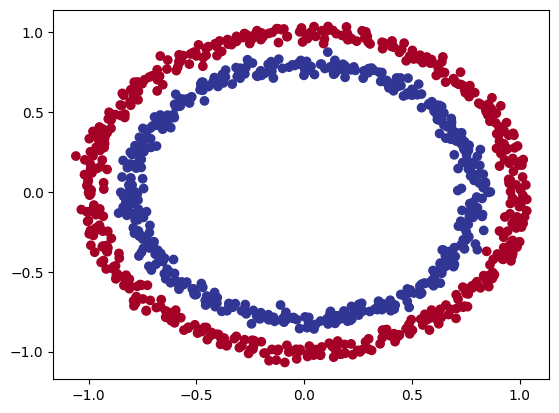

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### So we now with the colors added to each class we can visually see there are two sets (classes) of dots.

### We will use PyTorch to classify dots into two binary clasess Red and Blue

### Let's start by looking at the shape of our data ie Features and Labels


In [6]:
X.shape, y.shape

((1000, 2), (1000,))

### Let's go a little deeper and look at a single sample from the dataset.

In [7]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for the first sample of X: {X_sample} and y: {y_sample}")
print(f"Shapes for the first sample of X: {X_sample.shape} and y: {y_sample.shape}")

Values for the first sample of X: [0.75424625 0.23148074] and y: 1
Shapes for the first sample of X: (2,) and y: ()


### This shows us the Features (X) has two demensions and the Lables (Y) only have one single dimension. This looks good.  However, we will need to remember to use the PyTorch Squeeze function to so we only get the first dimension of each.

### Now that we have a better understanding of our data we want to do a little preprocessing on it.  We need to first cast it into tensors (NOTE: Numpy is 64bit floats but we want our Tensors to be 32bit Floats.  After that we can go ahead and randomly split the data into a training and test set.

In [8]:
#cast to tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Let's sample the first Five
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Randomly split data into train (80%) and test (20%) sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Now we are ready to build a Model to Train

### Let's start by getting our environment loaded with PyTorch and setting up some device agnostic code so that it will be able to run on either CPU's or GPUs. If you're running this on Colab and you see 'cpu' outputted you can go to the top menu, click Runtime, then change runtime type to GPU.


In [10]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Our model will take in features (X) and output something in the shape of our label (y).  This of course will be 0 or 1.  So given X output y.
### This is an example of **supervised learning**.  Since our model has labeled training examples.

In [11]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # In our first layer we are taking in our two features from X, then outputting five features **or neurons** to help the model learn
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # In the second layer we receive the five features from the previous layer do some calculations and output 1 feature which is our label (y)
        #NOTE We can stack as many layers as we want.  When we are working with more complex data (Images) this will be nice as the first layer may be linear looking for edges, then another layer may be nonlinear looking for curves etc..  If we have enough layers the model will learn shapes like eyes, noses etc...

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

### Let's test the model with some random data

In [12]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.9969],
        [1.0886],
        [0.6214],
        [1.1039],
        [0.4065],
        [0.4641],
        [0.8924],
        [0.7456],
        [0.6310],
        [1.0923]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Now we need to create our Loss and Optimizer functions

##Loss Function

#### For a linear regression problem we usually use mean absolute error (MAE) loss function or something similiar. But when it comes to binary classification we have other choices.  We will be using  binary cross entropy as the loss function. PyTorch has two binary cross entropy implementations (BCELoss and BCEWithLogitsLoss). We will be using BCEWithLogitsLoss for this implementation has it is more stable according to the docs. https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html


##Optimizer Function

#### We will once again use stochastic gradient descent for our optimizer (SGD) [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [13]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

##Accuracy

#### We will create our own accuracy function just to understand what's going on.  However, in the future we will use the built in accuracy function from

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

##Train the Model

###PyTorch training loop in Five steps

###1.  **Forward pass** - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).


###2.  **Calculate** the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).

###3.  **Zero gradients** - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).

###4.  **Perform backpropagation** on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).

###5.  **Step the optimizer** (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

In [15]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.75950, Accuracy: 50.00% | Test loss: 0.76724, Test acc: 50.00%
Epoch: 10 | Loss: 0.71748, Accuracy: 50.00% | Test loss: 0.72575, Test acc: 50.00%
Epoch: 20 | Loss: 0.70325, Accuracy: 58.75% | Test loss: 0.71086, Test acc: 58.00%
Epoch: 30 | Loss: 0.69803, Accuracy: 53.62% | Test loss: 0.70492, Test acc: 49.50%
Epoch: 40 | Loss: 0.69597, Accuracy: 52.38% | Test loss: 0.70228, Test acc: 50.00%
Epoch: 50 | Loss: 0.69508, Accuracy: 51.50% | Test loss: 0.70094, Test acc: 48.50%
Epoch: 60 | Loss: 0.69464, Accuracy: 51.25% | Test loss: 0.70015, Test acc: 48.00%
Epoch: 70 | Loss: 0.69438, Accuracy: 51.12% | Test loss: 0.69962, Test acc: 48.50%
Epoch: 80 | Loss: 0.69421, Accuracy: 51.12% | Test loss: 0.69922, Test acc: 46.50%
Epoch: 90 | Loss: 0.69407, Accuracy: 51.25% | Test loss: 0.69890, Test acc: 46.50%


In [16]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


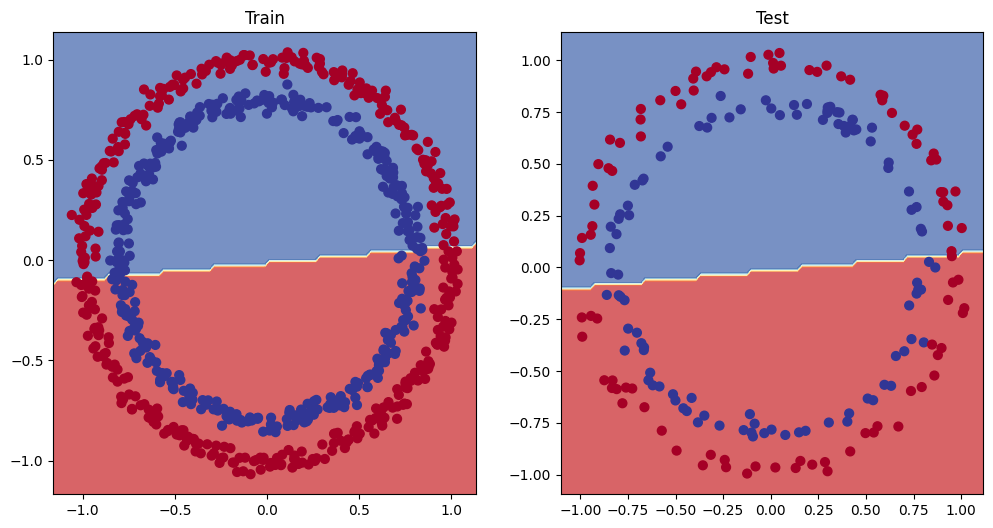

In [17]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [18]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [19]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [20]:
# Fit the model
torch.manual_seed(42)
epochs = 2000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

In [21]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

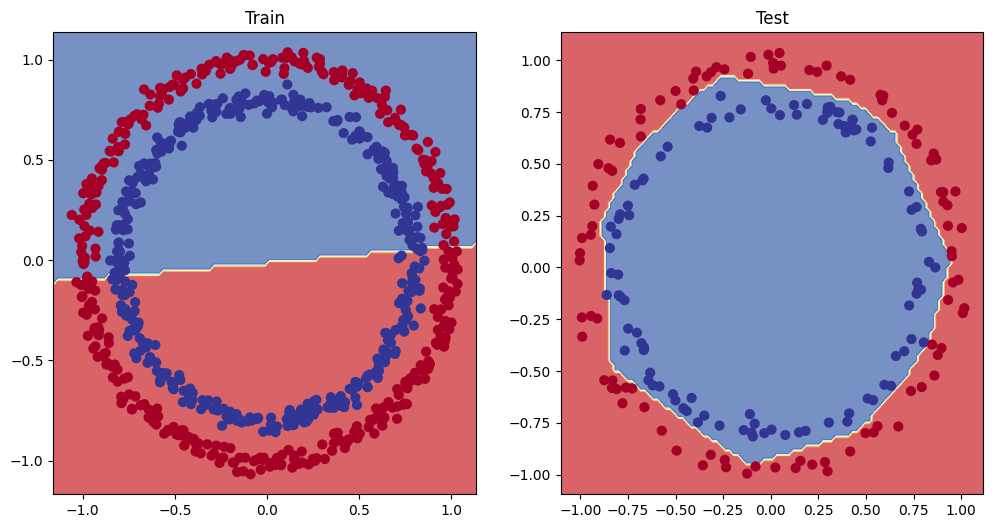

In [22]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity